In [ ]:
# Importing library modules

from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab.patches import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


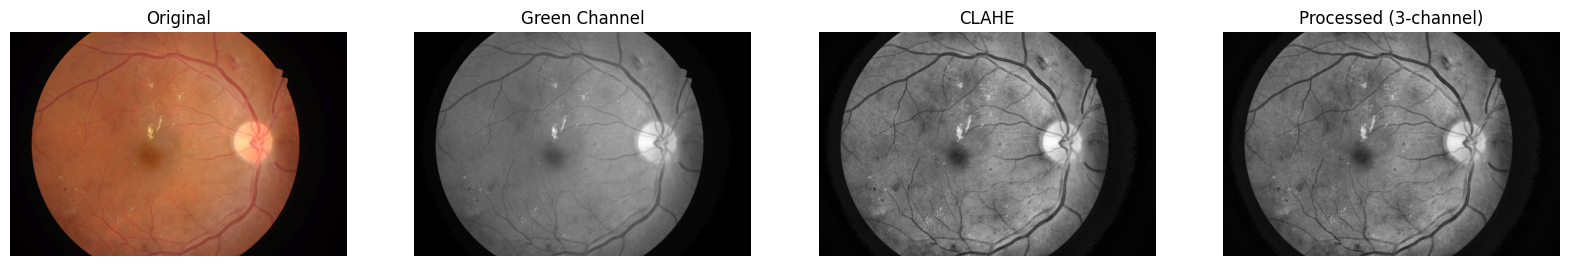

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128

# 1. Define preprocessing function
def preprocess_fundus(img):
    # Original
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract green channel
    green_channel = img[:, :, 1]

    # Apply CLAHE to green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_clahe = clahe.apply(green_channel)

    # Expand back to 3 channels for VGG19
    processed_img = cv2.merge([green_clahe, green_clahe, green_clahe])

    return original, green_channel, green_clahe, processed_img

# 2. Pick one test image
# For example: pick first image in training set
import os

base_path = "/content/drive/MyDrive/Grading_IDRiD"
train_dir = os.path.join(base_path, "1. Original Images", "a. Training Set")
sample_img = os.listdir(train_dir)[0]  # Get first filename

# Load sample image
img_path = os.path.join(train_dir, sample_img)
img = cv2.imread(img_path)

# Preprocess & get intermediate results
original, green_channel, green_clahe, processed_img = preprocess_fundus(img)

# 3. Visualize step by step
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(original)
axs[0].set_title("Original")

axs[1].imshow(green_channel, cmap='gray')
axs[1].set_title("Green Channel")

axs[2].imshow(green_clahe, cmap='gray')
axs[2].set_title("CLAHE")

axs[3].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
axs[3].set_title("Processed (3-channel)")

for ax in axs:
    ax.axis('off')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os

def load_idrid_data(image_dir, label_csv):
    df = pd.read_csv(label_csv)
    df.columns = df.columns.str.strip()
    X, y = [], []

    for _, row in df.iterrows():
        img_file = row['Image name'].strip() + ".jpg"
        label = int(row['Retinopathy grade'])
        path = os.path.join(image_dir, img_file)

        img = cv2.imread(path)
        if img is not None:
            # Using new preprocessing
            _, _, _, processed_img = preprocess_fundus(img)

            processed_img = cv2.resize(processed_img, (IMG_SIZE, IMG_SIZE))
            processed_img = processed_img / 255.0  # Normalizing

            X.append(processed_img)
            y.append(label)

    return np.array(X), np.array(y)

# Paths (same as before)
base_path = "/content/drive/MyDrive/Grading_IDRiD"

train_dir = os.path.join(base_path, "1. Original Images", "a. Training Set")
test_dir  = os.path.join(base_path, "1. Original Images", "b. Testing Set")

train_csv = os.path.join(base_path, "2. Groundtruths", "a. IDRiD_Disease Grading_Training Labels.csv")
test_csv  = os.path.join(base_path, "2. Groundtruths", "b. IDRiD_Disease Grading_Testing Labels.csv")

# Load full datasets
x_train, y_train = load_idrid_data(train_dir, train_csv)
x_test, y_test   = load_idrid_data(test_dir, test_csv)

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

Train: (413, 128, 128, 3) (413,)
Test : (103, 128, 128, 3) (103,)


In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

y_train = np.array(y_train)
y_test = np.array(y_test)

le = preprocessing.LabelEncoder()

y_train_encoded = le.fit_transform(y_train)


y_test_encoded = le.transform(y_test)

# One-hot encoding
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# Overwrite your variables
y_train = y_train_cat
y_test = y_test_cat

print("One-hot y_train shape:", y_train.shape)
print("One-hot y_test shape:", y_test.shape)
print("Label classes:", le.classes_)


One-hot y_train shape: (413, 5)
One-hot y_test shape: (103, 5)
Label classes: [0 1 2 3 4]


In [ ]:
from tensorflow.keras.applications import VGG19
model = VGG19(input_shape=(128, 128, 3), weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

activation = 'relu'
x = model.output
x = Flatten()(x)
x = Dense(128, activation=activation, kernel_initializer='he_uniform')(x)
x = Dropout(0.5) (x)
prediction_layer = Dense(5, activation='softmax')(x)

VGG19_model = Model(inputs=model.input, outputs=prediction_layer)

In [ ]:
for layers in VGG19_model.layers[:19]:
    print(layers)
    layers.trainable = False

VGG19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(VGG19_model.summary())

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<Conv2D name=block3_conv4, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<Conv2D name=block4_conv4, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             

 Total params: 21,073,733 (80.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,073,733 (80.39 MB)

None


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_gen = datagen.flow(x_train, y_train, batch_size=16)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("VGG19_model.keras", monitor='accuracy', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

history = VGG19_model.fit(
    x_train, y_train,
    epochs=20,
    callbacks=[checkpoint, early]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9619 - loss: 0.0984
Epoch 1: accuracy improved from -inf to 0.96126, saving model to VGG19_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.9619 - loss: 0.0990
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9660 - loss: 0.0833
Epoch 2: accuracy improved from 0.96126 to 0.96368, saving model to VGG19_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9658 - loss: 0.0840
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9663 - loss: 0.0913
Epoch 3: accuracy did not improve from 0.96368
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9661 - loss: 0.0920
Epoch 4/20
 2/13 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9375 - loss: 0.1474

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9561 - loss: 0.1247
Epoch 4: accuracy improved from 0.96368 to 0.96852, saving model to VGG19_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9570 - loss: 0.1235
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9630 - loss: 0.1278
Epoch 5: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9630 - loss: 0.1262
Epoch 6/20
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.0605

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9684 - loss: 0.1020
Epoch 6: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9682 - loss: 0.1021
Epoch 7/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9625 - loss: 0.1186
Epoch 7: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9618 - loss: 0.1185
Epoch 8/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9723 - loss: 0.0918
Epoch 8: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9719 - loss: 0.0927
Epoch 9/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9745 - loss: 0.0833
Epoch 9: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9734 - loss: 0.0854
Epoch 10/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9712 - loss: 0.0935
Epoch 10: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9710 - loss: 0.0943
Epoch 11/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9638 - loss: 0.1351
Epoch 11: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9640 - loss: 0.1329
Epoch 12/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9598 - loss: 0.1052
Epoch 12: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9601 - loss: 0.1056
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9393 - loss: 0.1215
Epoch 13: accuracy did not improve from 0.96852
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9404 - loss: 0.1203
Epoch 14/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9673 - loss: 0.1189
Epoch 14: accuracy improved from 0.96852 to 0.97337, saving model to VGG19_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9678 - loss: 0.1174
Epoch 15/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9614 - loss: 0.0910
Epoch 15: accuracy did not improve from 0.97337
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9615 - loss: 0.0919
Epoch 16/20
 2/13 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9531 - loss: 0.1028

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9733 - loss: 0.0824
Epoch 16: accuracy did not improve from 0.97337
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9731 - loss: 0.0832
Epoch 17/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9521 - loss: 0.1155
Epoch 17: accuracy did not improve from 0.97337
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9529 - loss: 0.1148
Epoch 18/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9607 - loss: 0.0890
Epoch 18: accuracy did not improve from 0.97337
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9606 - loss: 0.0898
Epoch 19/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9716 - loss: 0.1127
Epoch 19: accuracy improved from 0.97337 to 0.97821, saving model to VGG19_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9720 - loss: 0.1111
Epoch 20/20
 2/13 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9688 - loss: 0.1042

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9682 - loss: 0.0866
Epoch 20: accuracy did not improve from 0.97821
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9681 - loss: 0.0868


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


In [ ]:
loss, acc = VGG19_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.4346 - loss: 2.9287
Test Accuracy: 0.4563
